In [19]:
# Standard stuff
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

# ML stuff
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Concatenate, LeakyReLU
import tensorflow as tf

# IFN Architectures
# from GaussianAnsatz.Architectures.dnn import DNN
from GaussianAnsatz.archs import GaussianAnsatz
from GaussianAnsatz.archs import mine_loss, regulated_mine_loss, joint, marginal, MI
from GaussianAnsatz.utils import build_gaussianAnsatz_DNN, build_gaussianAnsatz_EFN, build_gaussianAnsatz_PFN, determine_constant


# Extra utils
from JEC.JEC_utils import load_data
from GaussianAnsatz.utils import plot_MI

In [20]:
y_dim = 1
x_dim = 3
loadfile = None
dnn_loadfile = "Models/DNN.hdf5"
efn_loadfile = "Models/EFN.hdf5"
pfn_loadfile = "Models/PFN.hdf5"
pfn_pid_loadfile = "Models/PFN_PID.hdf5"

cache_dir = "~/.energyflow"


# Models
model_keys = ["DNN", "EFN", "PFN", "PFN-PID", "CMS"]
models = {}

colors = ['red', 'yellow', 'green', 'blue', "purple"]
labels = ['DNN', "EFN", "PFN", "PFN-PID", "CMS"]

# Dataset Parameters
momentum_scale = 1000
n = 2500
pad = 150
pad_EFN = 150
pad_PFN = 150
pt_lower, pt_upper = 695, 705
eta = 2.4
quality = 2
epochs = 150
d_multiplier = 0.0

In [21]:
# #############################
# ########## DATASET ##########
# #############################

X_test, PFCs_test, Y_test, C_test, N_test = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 4, momentum_scale = momentum_scale, n = n, max_particle_select = 150)
test = (X_test, PFCs_test, Y_test, C_test)


plt.hist(N_test, bins=25, histtype = 'step', color = "red", label = "# of Particles", density=True)
plt.xlabel(r"$N$")
plt.ylabel("Density")
plt.title(r"Particle Count")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ############################
# ########## MODELS ##########
# ############################
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():
opt = tf.keras.optimizers.Adam()
DNN = build_gaussianAnsatz_DNN(x_dim, y_dim, [64, 64, 64], opt = opt)
EFN = build_gaussianAnsatz_EFN(x_dim, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(), pad_EFN, loadfile = efn_loadfile, d_multiplier = d_multiplier, opt = opt)
PFN = build_gaussianAnsatz_PFN(x_dim, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(),loadfile = pfn_loadfile, d_multiplier = d_multiplier, opt = opt)
PFN_pid = build_gaussianAnsatz_PFN(x_dim + 1, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(), loadfile = pfn_pid_loadfile, d_multiplier = d_multiplier, opt = opt)




# DNN loading is weird:
DNN.pre_train([X_test[:100],Y_test[:100]], epochs = 1, batch_size= 2, verbose = False)
DNN.load_weights(dnn_loadfile)



# place everything in a dictionary
models["DNN"] = DNN
models["EFN"] = EFN
models["PFN"] = PFN
models["PFN-PID"] = PFN_pid
models["CMS"] = None


def dnn_predict(test, model, c = 0):

    yhat, sigma, T, MI = DNN.eval(test[0], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def efn_predict(test, model, c = 0):
    yhat, sigma, T, MI = EFN.eval(test[1][:,:,:3], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def pfn_predict(test, model, c = 0):
    yhat, sigma, T, MI = model.eval(test[1][:,:,:3], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def pfn_pid_predict(test, model, c = 0):

    yhat, sigma, T, MI = model.eval(test[1], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def cms_predict(test, model, c = 0):
    x = test[0]
    pt = x[:,0]
    yhat = momentum_scale * np.multiply(pt, test[3])
    jer = np.sqrt( 30/yhat**2 + 0.81/yhat + 0.04**2   )
    return yhat, np.multiply(yhat, jer), np.zeros_like(yhat), 0.0


predictors = {}
predictors["DNN"] = dnn_predict
predictors["EFN"] = efn_predict
predictors["PFN"] = pfn_predict
predictors["PFN-PID"] = pfn_pid_predict
predictors["CMS"] = cms_predict

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, None, 2)]    0           []                               
                                                                                                  
 time_distributed_36 (TimeDistr  (None, None, 100)   300         ['input_26[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      multiple             0           ['time_distributed_36[0][0]',    
                                                                  'time_distributed_37[0][0]',    
                                                                  'time_distributed_38[0][0

In [ ]:
# from GaussianAnsatz.utils import plot_MI

# # Mutual Information plots
# names = ["DNN", "EFN", "PFN", "PFN_PID"]


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)
# plt.rcParams['font.size'] = '18'


# for (i, name) in enumerate(names):


#     MI = np.load("Models/%s.npy" % name)
#     plot_MI(600, MI, "_", [200, 400], color = colors[i], label = name, savefig = False)


# plt.xlabel("Epochs")
# plt.ylabel("I(X;Y)")
# plt.title("Learned Mutual Information")
# plt.legend()
# # plt.savefig("JEC/Plots/MI.pdf")
# plt.show()

Failed to predict for PFN


TypeError: 'NoneType' object is not subscriptable

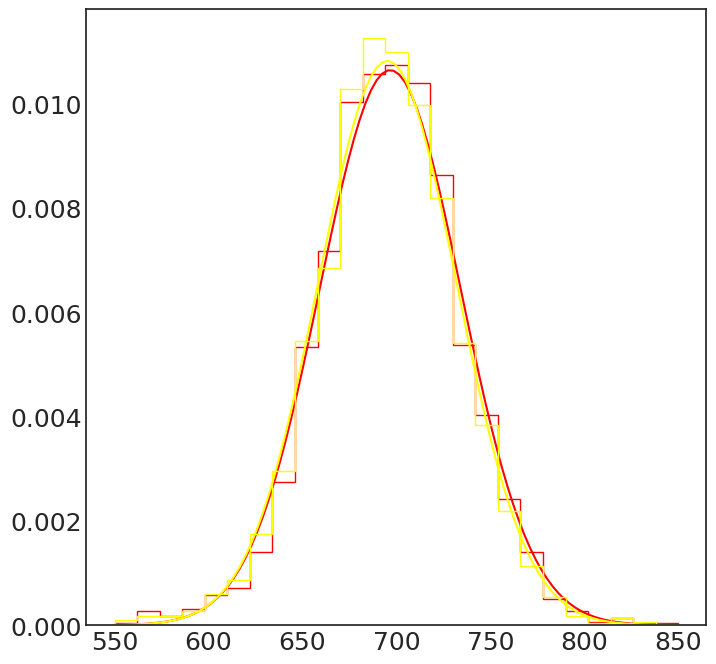

In [ ]:
# ##### PT Plots #####

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'

predictions = {}
passed = {}

for key in model_keys:
    try:
        predictions[key] = predictors[key](test, models[key])
        passed[key] = True
    except:
        predictions[key] = None
        passed[key] = False
        print("Failed to predict for %s" % key)




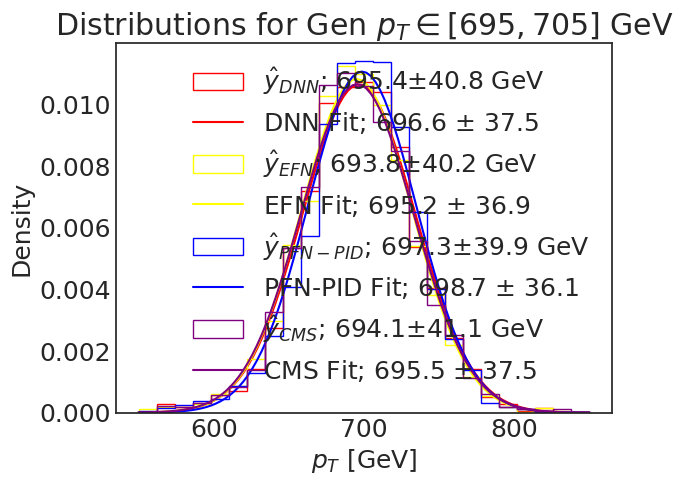

In [ ]:

# P_t distribution histograms
for (i, key) in enumerate(model_keys):

    if not passed[key]:
        continue

    mean, std = np.mean(predictions[key][0]), np.std(predictions[key][0])
    plt.hist(predictions[key][0], bins=25, range=[550,850], histtype = 'step', color = colors[i], label = r'$\hat{y}_{%s}$; %0.1f$\pm$%0.1f GeV' % (labels[i], mean, std), density=True)

    # Gaussian Fit
    temp = predictions[key][0][predictions[key][0] < 850]
    temp = predictions[key][0][predictions[key][0] > 550]
    x = np.linspace(550, 850, 100)
    fit = norm.pdf(x, *(norm.fit(temp)))
    plt.plot(x,fit, color = colors[i] ,label = r"%s Fit; %0.1f $\pm$ %0.1f" % (labels[i], *norm.fit(temp) )  )  

plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")
plt.legend()


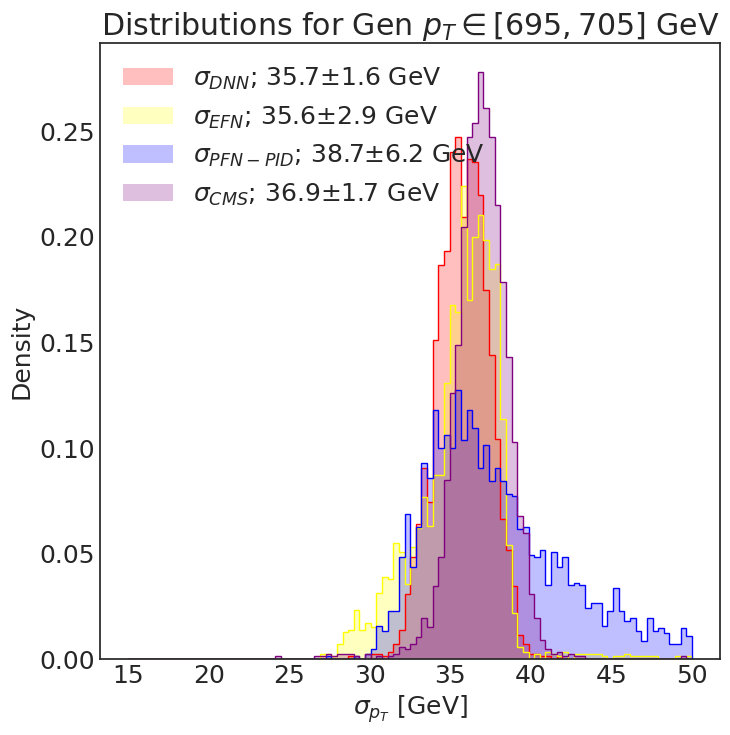

In [ ]:
# ##### UNCERTAINTY PLOTS #####

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'


# P_t uncertainty distribution histograms
for (i, key) in enumerate(model_keys):

    if not passed[key]:
        continue

    mean, std = np.mean(predictions[key][1]), np.std(predictions[key][1])
    plt.hist(predictions[key][1], bins=100, range=[15,50], histtype = 'stepfilled', alpha = 0.25, color = colors[i], label = r'$\sigma_{%s}$; %0.1f$\pm$%0.1f GeV' % (labels[i], mean, std), density=True)
    plt.hist(predictions[key][1], bins=100, range=[15,50], histtype = 'step', color = colors[i], density=True)

plt.xlabel(r"$\sigma_{p_T}$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")
# plt.grid()
plt.legend(loc = "upper left")
plt.savefig("Resolutions.pdf")
plt.show()

In [ ]:
# Dijet Loader

import energyflow as ef
from energyflow.utils import remap_pids

def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0, return_pfcs = True):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_gen_jet_eta < {eta}', f'quality >= {quality}']
    # specs = [f'{pt_lower} <= jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount, store_gens = False)

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    event_ids = np.zeros((Y1.shape[0],1), dtype = np.int32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    event_ids = sim.jets_i[:,sim.evn]



    # CMS JEC's
    C = sim.jets_f[:,sim.jec]

    # PFC's
    pfcs = sim.particles


    pfcs = pfcs[:n]
    Y = Y[:n]
    X = X[:n]
    C = C[:n]
    event_ids = event_ids[:n]
    pairs = pairs[:n]

    # PFC's
    dataset = np.zeros( (pfcs.shape[0], pad, x_dim), dtype = np.float32 )
    particle_counts = []
    if return_pfcs:
        for (i, jet) in enumerate(pfcs):
            size = min(jet.shape[0], pad)
            indices = (-jet[:,0]).argsort()
            dataset[i, :size, 0] = jet[indices[:size],0] / momentum_scale
            dataset[i, :size, 1] = jet[indices[:size],1]
            dataset[i, :size, 2] = jet[indices[:size],2]
            if x_dim == 4:
                dataset[i, :size, 3] = jet[indices[:size],4] # PID
            particle_counts.append(jet.shape[0])
        if x_dim == 4:
            remap_pids(dataset, pid_i = 3, error_on_unknown = False)

        for x in dataset:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  

    particle_counts = np.array(particle_counts)

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]
        C = C[particle_counts < max_particle_select]
        particle_counts = particle_counts[particle_counts < max_particle_select]


    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)
    print("PFCs: ", dataset.shape, dataset.dtype)

    if not return_pfcs:
        return X, Y, C, particle_counts, event_ids
   
    print("Max # of particles: %d" % max(particle_counts))
    return X, dataset, Y, C, particle_counts, event_ids



y_dim = 1
x_dim = 3



# Dataset Parameters
cache_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"
momentum_scale = 1000
n = 10000
pad = 150
pt_lower, pt_upper = 695, 705
eta = 2.4
quality = 2

# #############################
# ########## DATASET ##########
# #############################

X, pfcs, Y, C, N, ids = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = n, max_particle_select = None, amount = 1, return_pfcs= True)


sorted = np.sort(ids)
sorted_indices = ids.argsort()
print(ids.shape)
print(sorted)


counter = 0
pairs = []
N = len(sorted)
for (i,id) in enumerate(sorted):
    for (j, id2) in enumerate(sorted[(i+1):]):

        if id == id2:
            counter += 1
            pairs.append((i, i+1+j))
            break

        if id2 > id:
            break

print(counter / N )

X:  (4274, 3) float32
Y:  (4274, 1) float32
PFCs:  (4274, 150, 3) float32
Max # of particles: 169
(4274,)
[   3738    3746    3787 ... 3996718 3996792 3996820]
0.052877866167524566


In [ ]:
sorted_gen_pts = Y[sorted_indices]
sorted_Xs = X[sorted_indices]
sorted_Cs = C[sorted_indices]
sorted_pfcs =  pfcs[sorted_indices]

leading_gen_pts = []
subleading_gen_pts = []
leading_sim_pts = []
subleading_sim_pts = []
leading_Cs = []
subleading_Cs = []
leading_pfcs = []
subleading_pfcs = []

for pair in pairs:

    jet1 = sorted_gen_pts[pair[0]]
    jet2 = sorted_gen_pts[pair[1]]

    sim_jet1 = sorted_Xs[pair[0]]
    sim_jet2 = sorted_Xs[pair[1]]


    if jet1 > jet2:
        leading_gen_pts.append(jet1)
        subleading_gen_pts.append(jet2)

        leading_sim_pts.append(sim_jet1)
        subleading_sim_pts.append(sim_jet2)
        leading_Cs.append(sorted_Cs[pair[0]])
        subleading_Cs.append(sorted_Cs[pair[1]])
        leading_pfcs.append(sorted_pfcs[pair[0]])
        subleading_pfcs.append(sorted_pfcs[pair[1]])
    else:
        leading_gen_pts.append(jet2)
        subleading_gen_pts.append(jet1)

        leading_sim_pts.append(sim_jet2)
        subleading_sim_pts.append(sim_jet1)
        leading_Cs.append(sorted_Cs[pair[1]])
        subleading_Cs.append(sorted_Cs[pair[0]])
        leading_pfcs.append(sorted_pfcs[pair[1]])
        subleading_pfcs.append(sorted_pfcs[pair[0]])

leading_gen_pts = np.array(leading_gen_pts)
subleading_gen_pts = np.array(subleading_gen_pts)

leading_sim_pts = np.array(leading_sim_pts)
subleading_sim_pts = np.array(subleading_sim_pts)
leading_Cs =np.array(leading_Cs)
subleading_Cs=np.array(subleading_Cs)
leading_pfcs =np.array(leading_pfcs)
subleading_pfcs=np.array(subleading_pfcs)

leadings = [leading_sim_pts, leading_pfcs, leading_pfcs]
subleadings =[subleading_sim_pts, subleading_pfcs, subleading_pfcs]


39.269583071102936


InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse]

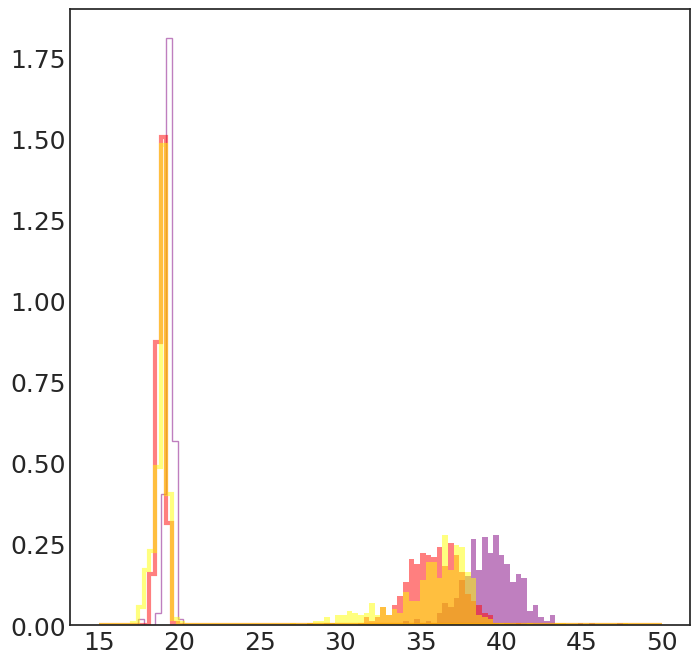

In [ ]:
   


Lambda = 22.3 / momentum_scale

# CMS Result
leading_predicts = leading_sim_pts[:,0] * leading_Cs
subleading_predicts = subleading_sim_pts[:,0] * subleading_Cs


detector_jet1 = np.copy(leading_predicts)
detector_jet2 = np.copy(subleading_predicts)
res1 = 1.06*leading_predicts * np.sqrt( 30/(momentum_scale * leading_predicts)**2 + 0.81/(momentum_scale * leading_predicts) + 0.04**2   ) 
res2 = 1.06*subleading_predicts * np.sqrt( 30/(momentum_scale * subleading_predicts)**2 + 0.81/(momentum_scale * subleading_predicts) + 0.04**2   ) 

# Math
var = np.sqrt(Lambda**2 + res1**2 + res2**2)
p1hathat = (detector_jet1 * Lambda**2 + detector_jet1 * res2**2 - detector_jet2 * res1**2) / var**2
p2hathat = (detector_jet2 * Lambda**2 - detector_jet1 * res2**2 + detector_jet2 * res1**2) / var**2

var1hathat = np.sqrt(1/(1/Lambda**2 + 1/res1**2))
var2hathat = np.sqrt(1/(1/Lambda**2 + 1/res2**2))


ptothathat = p1hathat + p2hathat
vartothathat = np.sqrt(var1hathat**2 + var2hathat**2)


concat_stds = momentum_scale * np.concatenate((res1, res2), axis = 0)
concat_stds_corrected = momentum_scale * np.concatenate((var1hathat,var2hathat), axis = 0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'

plt.hist(concat_stds, bins = 100, range = [15,50], label = "CMS", color = "purple", alpha = 0.5, density = True)
plt.hist(concat_stds_corrected, bins = 100, range = [15,50], label = "CMS Corr-Imp.", color = "purple", alpha = 0.5, histtype ="step", density = True)



print(np.mean(concat_stds))


for (i,model) in enumerate([DNN,EFN, PFN_PID]):
    detector_jet1, res1 = model.eval(leadings[i])
    detector_jet2, res2 = model.eval(subleadings[i])


    detector_jet1 = leading_predicts
    detector_jet2 = subleading_predicts
    # res1 = leading_stds
    # res2 = subleading_stds

    # Math
    var = np.sqrt(Lambda**2 + res1**2 + res2**2)
    p1hathat = (detector_jet1 * Lambda**2 + detector_jet1 * res2**2 - detector_jet2 * res1**2) / var**2
    p2hathat = (detector_jet2 * Lambda**2 - detector_jet1 * res2**2 + detector_jet2 * res1**2) / var**2

    var1hathat = np.sqrt(1/(1/Lambda**2 + 1/res1**2))
    var2hathat = np.sqrt(1/(1/Lambda**2 + 1/res2**2))


    ptothathat = p1hathat + p2hathat
    vartothathat = np.sqrt(var1hathat**2 + var2hathat**2)


    concat_stds = momentum_scale  * np.concatenate((res1, res2), axis = 0)
    concat_stds_corrected = momentum_scale * np.concatenate((var1hathat,var2hathat), axis = 0)

    plt.hist(concat_stds, bins = 100, range = [15,50], label = "GA %s" % labels[i], color = colors[i], alpha = 0.5, density = True)
    plt.hist(concat_stds_corrected, bins = 100, range = [15,50], label = "GA %s Corr-Imp." % labels[i], color = colors[i], alpha = 0.5, histtype ="step", density = True, lw = 3)


plt.legend(title = "$\Lambda = %.1f$ GeV" % (Lambda * 1000))
plt.xlabel(r"$\sigma_{p_T}$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")

plt.savefig("Correlation_Improved_Resolutions.pdf")


# Dijet Mass

In [ ]:
# Load in GEANT4 test set


def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0, return_pfcs = True):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount)

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    X[:,3] = sim.jets_f[:,sim.jet_m] / momentum_scale



    # CMS JEC's
    C = sim.jets_f[:,sim.jec]

    # PFC's
    pfcs = sim.particles

    # Shuffle and trim
    shuffle_indices = np.random.choice(np.arange(pfcs.shape[0]), size = int(pfcs.shape[0] * frac), replace=False)
    pfcs = pfcs[shuffle_indices]
    Y = Y[shuffle_indices]
    X = X[shuffle_indices]
    C = C[shuffle_indices]

    pfcs = pfcs[:n]
    Y = Y[:n]
    X = X[:n]
    C = C[:n]

    # PFC's
    dataset = np.zeros( (pfcs.shape[0], pad, x_dim), dtype = np.float32 )
    particle_counts = []
    if return_pfcs:
        for (i, jet) in enumerate(pfcs):
            size = min(jet.shape[0], pad)
            indices = (-jet[:,0]).argsort()
            dataset[i, :size, 0] = jet[indices[:size],0] / momentum_scale
            dataset[i, :size, 1] = jet[indices[:size],1]
            dataset[i, :size, 2] = jet[indices[:size],2]
            if x_dim == 4:
                dataset[i, :size, 3] = jet[indices[:size],4] # PID
            particle_counts.append(jet.shape[0])
        if x_dim == 4:
            remap_pids(dataset, pid_i = 3, error_on_unknown = False)

        for x in dataset:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  

    particle_counts = np.array(particle_counts)

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]
        C = C[particle_counts < max_particle_select]
        particle_counts = particle_counts[particle_counts < max_particle_select]

    shuffle_indices = np.random.choice(np.arange(dataset.shape[0]), size = int(dataset.shape[0] * frac), replace=False)

    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)
    print("PFCs: ", dataset.shape, dataset.dtype)

    if not return_pfcs:
        return X, Y, C, particle_counts
   
    print("Max # of particles: %d" % max(particle_counts))
    return X, dataset, Y, C, particle_counts



sim10 = ef.mod.load(dataset='sim',subdatasets=["SIM1000_Jet300_pT375-infGeV"])
gen10 = ef.mod.load(dataset='gen',subdatasets=["GEN1000_pT375-infGeV"])

sim14 = ef.mod.load(dataset='sim',subdatasets=["SIM1400_Jet300_pT375-infGeV"])
sim18 = ef.mod.load(dataset='sim',subdatasets=["SIM1800_Jet300_pT375-infGeV"])

gen14 = ef.mod.load(dataset='gen',subdatasets=["GEN1400_pT375-infGeV"])
gen18 = ef.mod.load(dataset='gen',subdatasets=["GEN1800_pT375-infGeV"])





In [ ]:





# TOOD: Convert Ben's code to my code.

#Truth
    pT1g = simjets[2*i,8]
    pT2g = simjets[2*i+1,8]
    
    y1g = simjets[2*i,9]
    y2g = simjets[2*i+1,9]
    
    phi1g = simjets[2*i,10]
    phi2g = simjets[2*i+1,10]
    
    m1g = simjets[2*i,11]
    m2g = simjets[2*i+1,11]
    
    ET1g = np.sqrt(pT1g**2+m1g**2)
    ET2g = np.sqrt(pT2g**2+m2g**2)
    
    mJJg = m1g**2+m2g**2+2*(ET1g*ET2g*np.cosh(y1g-y2g)-pT1g*pT2g*np.cos(phi1g-phi2g))
    mjjsg+=[mJJg**0.5]
    mjjsg+=[mJJg**0.5]
    pTsg+=[pT1g]
    pTsg+=[pT2g]
    etasg+=[y1g]
    etasg+=[y2g]